# 2. Feature Engineering
My solution is based on a wonderfull solution, provided by Denis Larionov: https://www.kaggle.com/dlarionov/feature-engineering-xgboost

In [7]:
%reset -f
# reset magic function. Allows one to release all previously used memory. -f (force) parameter allows to run it without confirmation from the user

%run libraries_and_functions
# jupyter magic function. Run libraries_and_functions.py - load standard libraries and custom functions from the created file.

Libraries and functions loaded


Training model...
LGBM: RMSE train: 1.185820118122173  RMSE val: 1.0608677586961452


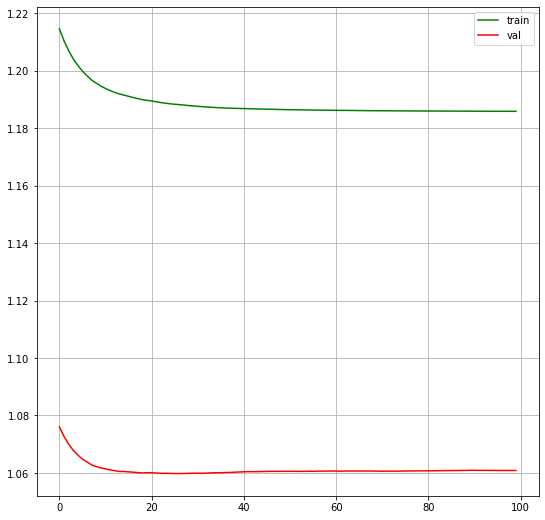

Plotting shap values...


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


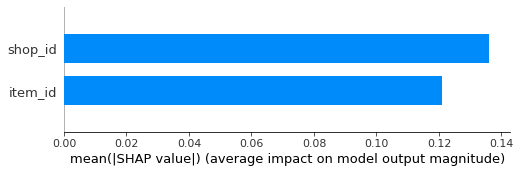

Wall time: 6min 26s


In [8]:
%%time

# Let's see initial solution
X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
X = X[X.date_block_num > 5]
X = X[X.date_block_num < 34]

# Run the base model
_ = LGBM(X)

## Time-Series Features
Here are some usefull links:
- Description of basic feature engineering in time series can be found here: https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/
- Modern time series predictions talk SciPy2019 https://www.youtube.com/watch?v=v5ijNXvlC5A
- Time series features generation paper https://arxiv.org/pdf/1901.10200.pdf 

In [14]:
# Load the data
train = pd.read_pickle(r'output/data/train_1.pkl')
    
X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
# Later, we save only newly generated features, and drop the loaded ones
columns_to_drop = X.columns

In [15]:
# Extract year number
X['year'] = X['date_block_num'] // 12 + 2013
# Month
X['month'] = X['date_block_num'] % 12
# Map number of days in the month (no leap years here)
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
X['days'] = X['month'].map(days)
# Shift month for convenience so that January is number 1, not 0
X['month'] = X['month'] + 1

# data from Russian working calender: January 2013 to November 2015
busdays = pd.Series([17,20,20,22,18,19,23,22,21,23,20,22,
                     17,20,20,22,19,19,23,21,22,23,18,23,
                     15,19,21,22,18,21,23,21,22,22,20]) 

X['busdays'] = X['date_block_num'].map(busdays)
holidays = pd.Series([6,1,1,0,5,1,0,0,0,0,1,1,
                      6,1,1,0,4,2,0,0,0,0,2,1,
                      7,1,1,0,3,1,0,0,0,0,1]) 

X['holidays'] = X['date_block_num'].map(holidays)

In [16]:
%%time
# Let's convert our date to datetime format
train['date'] = pd.to_datetime(train.date, dayfirst = True) # Keep date only (no hours, minutes, seconds)

import datetime
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek

# Let us add how many each of the weekdays are there in the dataframe so that the sales are not zero at this day

# First group items based on date, shop_id, and date_block num
cols = ['date', 'shop_id', 'date_block_num']
group = train.groupby(cols).agg({'day_of_week': ['min']})
group.columns = ['days']
group.reset_index(inplace=True)
#display(group.head(3))

# Now we create columns for each of the weekdays
X['salesdays'] = 0; X['mo'] = 0; X['tu'] = 0; X['we'] = 0; X['th'] = 0; X['fr'] = 0; X['sa'] = 0; X['su'] = 0 

# iterate over month, shop and day to count how many each of the days are there

# iterate over months:
months = set(group.date_block_num)
for month in months:
    #print('month =', month)
    
    #iterate over shops in this month
    shops = set(group[group.date_block_num == month].shop_id)
    for shop in shops:
        mo = 0; tu = 0; we = 0; th = 0; fr = 0; sa = 0; su = 0
        
        # iterate over days for current month and shop:
        days = group[(group.shop_id == shop) & (group.date_block_num == month)].days
        for day in days:
            if day == 0: mo+=1
            if day == 1: tu+=1
            if day == 2: we+=1
            if day == 3: th+=1
            if day == 4: fr+=1
            if day == 5: sa+=1
            if day == 6: su+=1
        salesdays = mo+tu+we+th+fr+sa+su
        
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'mo'] = mo # add values to X
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'tu'] = tu
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'we'] = we
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'th'] = th        
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'fr'] = fr
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'sa'] = sa
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'su'] = su
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'salesdays'] = salesdays
        # Lets print obtained resulst for last month of train:
        if month == 33:
            print('shop_id = ', shop, 'salesdays = ', salesdays, mo, tu, we, th, fr, sa, su)

shop_id =  2 salesdays =  31 4 4 4 5 5 5 4
shop_id =  3 salesdays =  31 4 4 4 5 5 5 4
shop_id =  4 salesdays =  31 4 4 4 5 5 5 4
shop_id =  5 salesdays =  31 4 4 4 5 5 5 4
shop_id =  6 salesdays =  31 4 4 4 5 5 5 4
shop_id =  7 salesdays =  31 4 4 4 5 5 5 4
shop_id =  11 salesdays =  31 4 4 4 5 5 5 4
shop_id =  12 salesdays =  24 4 4 4 5 5 0 2
shop_id =  14 salesdays =  31 4 4 4 5 5 5 4
shop_id =  15 salesdays =  30 4 4 4 5 5 4 4
shop_id =  16 salesdays =  31 4 4 4 5 5 5 4
shop_id =  18 salesdays =  31 4 4 4 5 5 5 4
shop_id =  19 salesdays =  31 4 4 4 5 5 5 4
shop_id =  21 salesdays =  31 4 4 4 5 5 5 4
shop_id =  22 salesdays =  31 4 4 4 5 5 5 4
shop_id =  24 salesdays =  30 4 4 4 5 5 4 4
shop_id =  25 salesdays =  31 4 4 4 5 5 5 4
shop_id =  26 salesdays =  31 4 4 4 5 5 5 4
shop_id =  28 salesdays =  31 4 4 4 5 5 5 4
shop_id =  31 salesdays =  31 4 4 4 5 5 5 4
shop_id =  34 salesdays =  31 4 4 4 5 5 5 4
shop_id =  35 salesdays =  31 4 4 4 5 5 5 4
shop_id =  36 salesdays =  14 2 2 2 2 

Not all shops sell items all 31 days in October 2015. Internet shop # 12 shows minor or zero sales on weekends.Closed shops show zero sales. 

In [17]:
# Now let us add the data for test set manually 
X.loc[(X.date_block_num == 34), 'mo'] = 4
X.loc[(X.date_block_num == 34), 'tu'] = 4
X.loc[(X.date_block_num == 34), 'we'] = 4
X.loc[(X.date_block_num == 34), 'th'] = 4
X.loc[(X.date_block_num == 34), 'fr'] = 4
X.loc[(X.date_block_num == 34), 'sa'] = 5
X.loc[(X.date_block_num == 34), 'su'] = 5
X.loc[(X.date_block_num == 34), 'salesdays'] = 30

# With different values for shop # 12
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'mo'] = 4 
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'tu'] = 4
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'we'] = 4
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'th'] = 4        
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'fr'] = 4
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'sa'] = 0
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'su'] = 0
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'salesdays'] = 20

In [18]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_TimeFeatures.pkl')

,year,month,days,busdays,holidays,salesdays,mo,tu,we,th,fr,sa,su
0,2013,1,31,17,6,25,3,4,4,4,4,3,3
1,2013,1,31,17,6,25,3,4,4,4,4,3,3
2,2013,1,31,17,6,25,3,4,4,4,4,3,3


,year,month,days,busdays,holidays,salesdays,mo,tu,we,th,fr,sa,su
10874955,2015,11,30,20,1,30,4,4,4,4,4,5,5
10874956,2015,11,30,20,1,30,4,4,4,4,4,5,5
10874957,2015,11,30,20,1,30,4,4,4,4,4,5,5


## Shops-Items-Cats Features

Tfidf (term frequency–inverse document frequency https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is ML technique (https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html), which is often used to extract text features.   
Here it is used to extract features from item_name column of 'items' dataset. The common scheme is shown here: https://www.geeksforgeeks.org/sklearn-feature-extraction-with-tf-idf/, but instead of cosine/manhatten, etc. distances, KMean clustering is implemented here.

In [19]:
%reset -f

%run libraries_and_functions

Libraries and functions loaded


In [20]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA

import scipy.sparse # PCA doesn't accept sparse matrixes produced by CountVectorizer

# I also tried NMF, LDA approaches and kmeans but they showed worse results than PCA: PCA>LDA>NMF (at the same number of components)
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.decomposition import NMF
# from sklearn.cluster import KMeans

In [21]:
# Load data from previous part
shops = pd.read_pickle(r'output/data/shops_1.pkl')
items = pd.read_pickle(r'output/data/items_1.pkl')
cats = pd.read_pickle(r'output/data/cats_1.pkl')

X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
columns_to_drop = X.columns

#### Shops

In [22]:
shops.head(3)

,shop_name,shop_id
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [23]:
# Extract city name from shops set:
shops['city'] = shops['shop_name'].str.split().map(lambda x: x[0])
shops['city'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city']]
# Now add extracted features to X
X = pd.merge(X, shops, on=['shop_id'], how='left')

#### Items

In [24]:
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [25]:
%%time
# Bag of words approach
vect = CountVectorizer(min_df = 7, ngram_range=(1, 10), stop_words='english') # no russian stop words unfortunatly in CountVectorizer
vect.fit(items.item_name)
# feature_names = vect.get_feature_names(); print(feature_names)

bag_of_words = vect.transform(items.item_name)    
bag_of_words =pd.DataFrame.sparse.from_spmatrix(bag_of_words) # transform to dense since PCA doesn't work with sparse matrices
print('vocabulary len: ',len(vect.vocabulary_))

pca = PCA(n_components=9, random_state = 42)
pca_components = pca.fit_transform(bag_of_words)
pca_components_df =  pd.DataFrame(pca_components, columns=['itemspca0', 'itemspca1', 'itemspca2', 'itemspca3', 'itemspca4', 'itemspca5', 'itemspca6', 'itemspca7', 'itemspca8'])
items = pd.concat([items, pca_components_df], axis=1)

vocabulary len:  5771
Wall time: 6.85 s


In [26]:
# Now move the features from 'items' to 'X'
items.drop(['item_name'], axis=1, inplace=True)
X = pd.merge(X, items, on=['item_id'], how='left')

#### Cats

In [27]:
cats.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3


In [28]:
# Extract features from 'categories' set
cats['type'] = cats['item_category_name'].str.split('-').map(lambda x: x[0].strip())
cats['catstype'] = LabelEncoder().fit_transform(cats['type'])

# if subtype is nan then type
cats['subtype'] = cats['item_category_name'].str.split('-').map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['catssubtype'] = LabelEncoder().fit_transform(cats['subtype'])
#cats = cats[['item_category_id','type_code', 'subtype_code']]

In [29]:
vect = CountVectorizer(min_df = 2, ngram_range=(1, 10), stop_words='english')
bag_of_words = vect.fit_transform(cats.item_category_name)    
bag_of_words =pd.DataFrame.sparse.from_spmatrix(bag_of_words) # transform to dense since PCA doesn't work with sparse matrices
print('vocabulary len: ',len(vect.vocabulary_))

pca = PCA(n_components=2, random_state = 42)
pca_components = pca.fit_transform(bag_of_words)
pca_components_df =  pd.DataFrame(pca_components, columns=['catspca0', 'catspca1'])
cats = pd.concat([cats, pca_components_df], axis=1)

cats.drop(columns = ['item_category_name', 'type', 'subtype'], inplace = True)
X = pd.merge(X, cats, on=['item_category_id'], how='left')

vocabulary len:  60


In [30]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_ShopsItemsCatsFeatures.pkl')

,city,item_category_id,itemspca0,itemspca1,itemspca2,itemspca3,itemspca4,itemspca5,itemspca6,itemspca7,itemspca8,catstype,catssubtype,catspca0,catspca1
0,0,40,-0.237778,-0.114611,-0.049016,-0.100027,-0.075281,0.081794,0.256037,0.035067,0.063871,9,4,-0.065215,0.152159
1,0,19,0.363063,1.543231,-0.199330,0.188996,-0.273920,-0.958190,0.333292,0.234913,-0.073300,4,9,0.078750,-0.648043
2,0,30,0.392010,1.607531,0.344792,0.449975,-0.712281,0.118114,0.081431,-0.239582,0.141226,7,42,-0.042290,0.120925


,city,item_category_id,itemspca0,itemspca1,itemspca2,itemspca3,itemspca4,itemspca5,itemspca6,itemspca7,itemspca8,catstype,catssubtype,catspca0,catspca1
10874955,19,55,-0.258264,-0.083879,-0.084319,-0.093809,-0.055418,-0.008918,0.001779,0.084556,-0.056199,11,2,0.666465,-0.125132
10874956,19,40,-0.260087,-0.087209,-0.085385,-0.095020,-0.058140,-0.010488,-0.003297,0.062235,-0.046255,9,4,-0.065215,0.152159
10874957,19,37,-0.315630,-0.222623,-0.207177,0.742574,0.239475,-0.006593,-0.013620,-0.082783,0.042240,9,1,0.021547,0.144545


## Target Features

#### Target Lag Features

In [31]:
X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
columns_to_drop = X.columns

In [32]:
X = lag_feature(X, [1,12], 'item_cnt_month')

In [33]:
X = lag_feature(X, [2], 'item_cnt_month') # T for target
X['last_diff'] = X.item_cnt_month_lag_1 - X.item_cnt_month_lag_2
X.drop(columns = ['item_cnt_month_lag_2'], inplace = True)

In [34]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_TargetLagFeatures.pkl')

,item_cnt_month_lag_1,item_cnt_month_lag_12,last_diff
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN


,item_cnt_month_lag_1,item_cnt_month_lag_12,last_diff
10874955,0.0,0.0,0.0
10874956,0.0,NaN,0.0
10874957,0.0,0.0,0.0


### Target First-Last Sales Features

In [35]:
X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
columns_to_drop = X.columns

In [37]:
%%time
# Let us get all sales values in time for each item/shop/month. Column name is corresponding the lag month
tmp = X.copy()                                                                          #Create temporary dataframe
for i in range(34,0,-1): 
    shifted = tmp.iloc[:,0:4]                                                           # Take first 4 columns from tmp dataframe
    shifted.columns = ['date_block_num','shop_id','item_id', str(i)]                    # Column names correspond to lag
    shifted['date_block_num'] += i                                                      #change date_block_num to shifted value
    tmp = pd.merge(tmp, shifted, on=['date_block_num','shop_id','item_id'], how='left') #merge the shifted column to main df on three columns
tmp = tmp.iloc[:,4:]

downcast(tmp)

tmp_nan = tmp.replace(0, np.nan)
display(tmp.tail(10), tmp_nan.tail(10))

,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1
10874948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10874949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
10874950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10874951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
10874952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
10874953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10874954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
10874955,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10874956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10874957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1
10874948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
10874949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10874950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10874951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN
10874952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10874953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
10874954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10874955,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10874956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10874957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Wall time: 4min 56s


In [38]:
%%time
X['first_sale_month_all_shops'] = tmp.apply(lambda row: row.first_valid_index(), axis = 1)
X['last_sale_month_all_shops'] = tmp.apply(lambda row: row.last_valid_index(), axis = 1)

X['first_sale_month'] = tmp_nan.apply(lambda row: row.first_valid_index(), axis = 1)
X['last_sale_month'] = tmp_nan.apply(lambda row: row.last_valid_index(), axis = 1)

Wall time: 11min 30s


In [39]:
X['max_sale_month'] = tmp_nan.idxmax(axis=1, skipna=True)

In [40]:
# Is the item new?
X['no_item_shop_sales'] = X.last_sale_month.isna().astype('int8')
# Is there any item-shop_id sales history in the previous data?
X['new_item'] = X.last_sale_month_all_shops.isna().astype('int8')

In [41]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_FirstLastSalesFeatures.pkl')

,first_sale_month_all_shops,last_sale_month_all_shops,first_sale_month,last_sale_month,max_sale_month,no_item_shop_sales,new_item
0,NaN,NaN,NaN,NaN,NaN,1,1
1,NaN,NaN,NaN,NaN,NaN,1,1
2,NaN,NaN,NaN,NaN,NaN,1,1


,first_sale_month_all_shops,last_sale_month_all_shops,first_sale_month,last_sale_month,max_sale_month,no_item_shop_sales,new_item
10874955,34.0,1.0,34.0,9.0,24.0,0,0
10874956,11.0,1.0,NaN,NaN,NaN,1,0
10874957,17.0,1.0,17.0,15.0,17.0,0,0


### Target Stat Features

In [42]:
X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
columns_to_drop = X.columns

In [43]:
X['nonzero_sales_freq'] = tmp_nan.count(axis = 1)/tmp.count(axis = 1)

X['target_mean'] = tmp.mean(axis = 1)
X['target_std'] = tmp.std(axis = 1)

X['target_std_to_mean'] = X['target_std']/X['target_mean']

In [44]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_TargetStatFeatures.pkl')

,nonzero_sales_freq,target_mean,target_std,target_std_to_mean
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN


,nonzero_sales_freq,target_mean,target_std,target_std_to_mean
10874955,0.176471,0.205882,0.478597,2.324615
10874956,0.000000,0.000000,0.000000,NaN
10874957,0.176471,0.294118,0.771743,2.623928


### Target EWM Features

In [45]:
X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
columns_to_drop = X.columns

In [46]:
%%time
#Now let us calculate EWM features from tmp dataframe
X['EWM_mean_span2']=tmp.ewm(span=2,adjust=True, ignore_na=False, axis = 1).mean().iloc[:,-1]
X['EWM_mean_span3']=tmp.ewm(span=3,adjust=True, ignore_na=False, axis = 1).mean().iloc[:,-1]
X['EWM_mean_span6']=tmp.ewm(span=6,adjust=True, ignore_na=False, axis = 1).mean().iloc[:,-1]
X['EWM_mean_span12']=tmp.ewm(span=12,adjust=True, ignore_na=False, axis = 1).mean().iloc[:,-1]

Wall time: 3min 50s


In [47]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_TargetEWMFeatures.pkl')

,EWM_mean_span2,EWM_mean_span3,EWM_mean_span6,EWM_mean_span12
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN


,EWM_mean_span2,EWM_mean_span3,EWM_mean_span6,EWM_mean_span12
10874955,1.354876e-04,0.002936,0.035049,0.098788
10874956,0.000000e+00,0.000000,0.000000,0.000000
10874957,2.323057e-07,0.000069,0.008371,0.062942


## Price Features

In [48]:
X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
columns_to_drop = X.columns

train = pd.read_pickle(r'output/data/train_1.pkl')

### Price Variation Lag 1

In [49]:
tmp = X.iloc[:, 0:3]
# calculate mean item_price for each item
tmp = aggregate(tmp, train, ['item_id'], {'item_price': ['mean']}, ['item_avg_item_price'])
# calculate mean item_price for each item in each month
tmp = aggregate(tmp, train, ['date_block_num','item_id'], {'item_price': ['mean']}, ['date_item_avg_item_price'])
# calculate relative (to overall mean item price) price change for each item in each month
tmp['delta_price'] = (tmp['date_item_avg_item_price'] - tmp['item_avg_item_price']) / tmp['item_avg_item_price']
# calculate shifted feature
tmp = lag_feature(tmp,[1],'delta_price')
# copy to X and fill NaN with 0
X['delta_price_lag_1'] = tmp['delta_price_lag_1']#.fillna(0)

# Price aggregates per each item, month, and shop 
tmp = aggregate(tmp, train, ['date_block_num','shop_id','item_id'], {'item_price': ['mean']}, ['shop_date_item_avg_item_price'])
tmp['delta_price_shop'] = (tmp['shop_date_item_avg_item_price'] - tmp['date_item_avg_item_price']) / tmp['date_item_avg_item_price']
tmp = lag_feature(tmp,[1],'delta_price_shop')
X['delta_price_shop_lag_1'] = tmp['delta_price_shop_lag_1']

### RUB/USD Exchange Rate

In [50]:
# Due to oil prices drop/sanctions/etc Russian economy was not stable during the studied period. RUB/USD currency exchange ratio should be a help to understand situation in economy. It will also be a good corrector for prices. 
# Exchange rates are taken from: https://www.x-rates.com/average/?from=USD&to=RUB&amount=1&year=2015
usd = pd.Series([30.244074,30.179667,30.816639,31.347389,31.325703,32.309459,32.768906,32.992554,32.601117,32.077595,32.687824,32.867809,
                  33.675610,35.245171,36.195442,35.658811,34.918525,34.392044,34.684944,36.144526,37.951523,40.815324,46.257598,55.966912,
                  63.676710,64.443511,60.261687,53.179035,50.682796,54.610770,57.155767,65.355082,66.950360,63.126499,65.083095]) 
X['rub_to_usd'] = X['date_block_num'].map(usd)
#plt.plot(X.date_block_num, X.rub_to_usd); plt.show()

### Price Aggregate Statistics Lag 1

In [51]:
%%time
# Let's calculate price aggregates. We see multimodal distribution of data.

# Price aggregates per each item
X = aggregate(X, train, ['item_id'], {'item_price': ['std']}, ['std_price_per_item'])
X = aggregate(X, train, ['item_id'], {'item_price': ['mean']}, ['mean_price_per_item'])
X = aggregate(X, train, ['item_id'], {'item_price': ['min']}, ['min_price_per_item'])
X = aggregate(X, train, ['item_id'], {'item_price': ['max']}, ['max_price_per_item'])
# Price aggregates per each item and month
X = aggregate(X, train, ['date_block_num','item_id'], {'item_price': ['std']}, ['std_price_per_item_month'])
X = aggregate(X, train, ['date_block_num','item_id'], {'item_price': ['mean']}, ['mean_price_per_item_month'])
X = aggregate(X, train, ['date_block_num','item_id'], {'item_price': ['min']}, ['min_price_per_item_month'])
X = aggregate(X, train, ['date_block_num','item_id'], {'item_price': ['max']}, ['max_price_per_item_month'])
# Price aggregates per each item, month, and shop
X = aggregate(X, train, ['date_block_num','shop_id','item_id'], {'item_price': ['std']}, ['std_price_per_item_month_shop'])
X = aggregate(X, train, ['date_block_num','shop_id','item_id'], {'item_price': ['mean']}, ['mean_price_per_item_month_shop'])
X = aggregate(X, train, ['date_block_num','shop_id','item_id'], {'item_price': ['min']}, ['min_price_per_item_month_shop'])
X = aggregate(X, train, ['date_block_num','shop_id','item_id'], {'item_price': ['max']}, ['max_price_per_item_month_shop'])

# Calculate lag features and drop original
X = lag_feature(X, [1], 'std_price_per_item', drop = True)
X = lag_feature(X, [1], 'mean_price_per_item', drop = True)
X = lag_feature(X, [1], 'min_price_per_item', drop = True)
X = lag_feature(X, [1], 'max_price_per_item', drop = True)

X = lag_feature(X, [1], 'std_price_per_item_month', drop = True)
X = lag_feature(X, [1], 'mean_price_per_item_month', drop = True)
X = lag_feature(X, [1], 'min_price_per_item_month', drop = True)
X = lag_feature(X, [1], 'max_price_per_item_month', drop = True)

X = lag_feature(X, [1], 'std_price_per_item_month_shop', drop = True)
X = lag_feature(X, [1], 'mean_price_per_item_month_shop', drop = True)
X = lag_feature(X, [1], 'min_price_per_item_month_shop', drop = True)
X = lag_feature(X, [1], 'max_price_per_item_month_shop', drop = True)

Wall time: 2min 59s


In [52]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_PriceFeatures.pkl')

,delta_price_lag_1,delta_price_shop_lag_1,rub_to_usd,std_price_per_item_lag_1,mean_price_per_item_lag_1,min_price_per_item_lag_1,max_price_per_item_lag_1,std_price_per_item_month_lag_1,mean_price_per_item_month_lag_1,min_price_per_item_month_lag_1,max_price_per_item_month_lag_1,std_price_per_item_month_shop_lag_1,mean_price_per_item_month_shop_lag_1,min_price_per_item_month_shop_lag_1,max_price_per_item_month_shop_lag_1
0,NaN,NaN,30.244074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30.244074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,30.244074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,delta_price_lag_1,delta_price_shop_lag_1,rub_to_usd,std_price_per_item_lag_1,mean_price_per_item_lag_1,min_price_per_item_lag_1,max_price_per_item_lag_1,std_price_per_item_month_lag_1,mean_price_per_item_month_lag_1,min_price_per_item_month_lag_1,max_price_per_item_month_lag_1,std_price_per_item_month_shop_lag_1,mean_price_per_item_month_shop_lag_1,min_price_per_item_month_shop_lag_1,max_price_per_item_month_shop_lag_1
10874955,0.155905,NaN,65.083092,19.826221,198.113205,110.0,229.0,0.000000,229.000000,229.000000,229.0,NaN,NaN,NaN,NaN
10874956,-0.091709,NaN,65.083092,4.736330,98.096298,70.0,99.0,14.000714,89.099998,79.199997,99.0,NaN,NaN,NaN,NaN
10874957,-0.605811,NaN,65.083092,96.867386,502.297058,198.0,549.0,0.000000,198.000000,198.000000,198.0,NaN,NaN,NaN,NaN


## Solution 

In [ ]:
%reset -f
%run libraries_and_functions

In [3]:
X = pd.concat([pd.read_pickle(r'output/data/X_1_EDA.pkl'),
               pd.read_pickle(r'output/data/X_TimeFeatures.pkl'),
               pd.read_pickle(r'output/data/X_ShopsItemsCatsFeatures.pkl'),
               pd.read_pickle(r'output/data/X_FirstLastSalesFeatures.pkl'),
               pd.read_pickle(r'output/data/X_TargetStatFeatures.pkl'),
               pd.read_pickle(r'output/data/X_TargetEWMFeatures.pkl'),
               pd.read_pickle(r'output/data/X_TargetLagFeatures.pkl'),
               pd.read_pickle(r'output/data/X_PriceFeatures.pkl'),
              ], axis=1)

# First 6 month removal
X = X[X.date_block_num > 5]
# Test month drop
X = X[X.date_block_num < 34]

Libraries and functions loaded


Training model...
LGBM: RMSE train: 0.8217087857933523  RMSE val: 0.8121039765974986


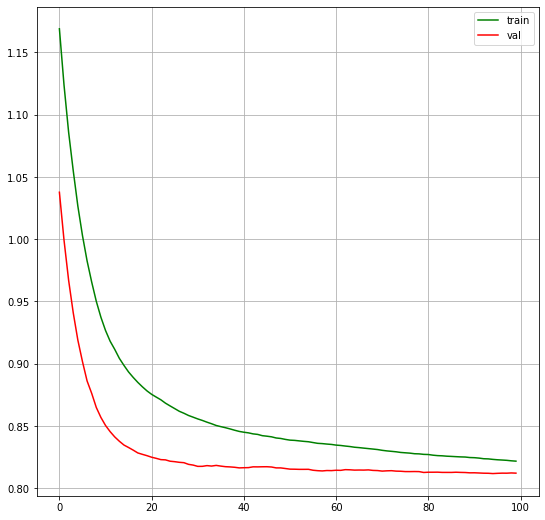

Plotting shap values...


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


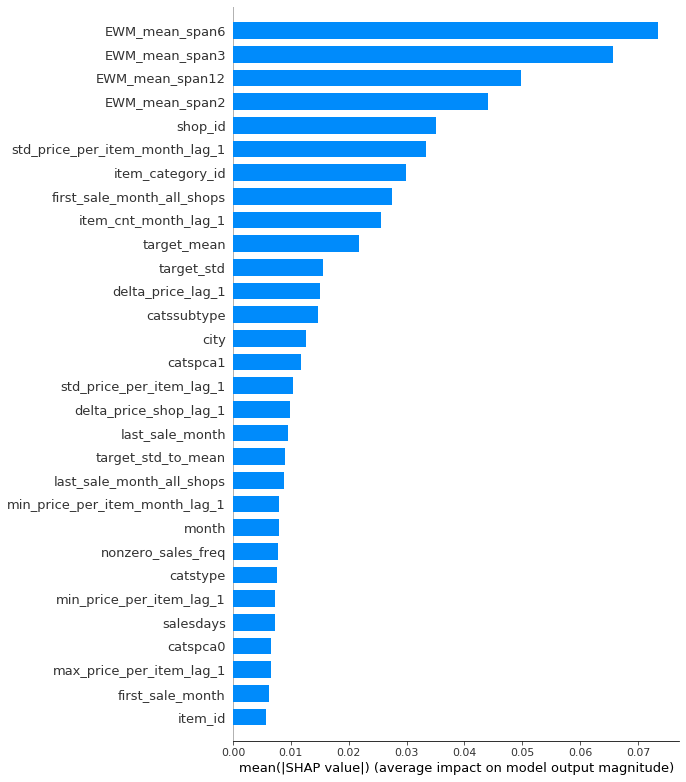

Wall time: 13min 10s


In [4]:
%%time
_ = LGBM(X)

In [5]:
_, _, FI = _

In [6]:
FI

,col_name,feature_importance_vals
43,EWM_mean_span6,0.073455
42,EWM_mean_span3,0.065733
44,EWM_mean_span12,0.049726
41,EWM_mean_span2,0.044041
0,shop_id,0.035087
55,std_price_per_item_month_lag_1,0.033302
16,item_category_id,0.029914
30,first_sale_month_all_shops,0.027401
45,item_cnt_month_lag_1,0.025495
38,target_mean,0.021820


## Features Encodings DL

In [9]:
%reset -f
%run libraries_and_functions

Libraries and functions loaded


Good comparison of different encodings and regularizations: Mean (likelihood) encoding for categorical variables with high cardinality and feature interactions: a comprehensive study with Python: https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study

In [10]:
X = pd.concat([pd.read_pickle(r'output/data/X_1_EDA.pkl'),
               pd.read_pickle(r'output/data/X_TimeFeatures.pkl'),
               pd.read_pickle(r'output/data/X_ShopsItemsCatsFeatures.pkl'),
              ], axis=1)

columns_to_drop = X.columns

In [11]:
%%time 
# The way was done by DLarionov
X = kfmean_lag_feature(X,['date_block_num'],                               'date_avg_item_cnt',             [1], tr_test_split = 34)
X = kfmean_lag_feature(X,['date_block_num', 'item_id'],                    'date_item_avg_item_cnt',        [1,2,3,4,5,6], tr_test_split = 34)
X = kfmean_lag_feature(X,['date_block_num', 'shop_id'],                    'date_shop_avg_item_cnt',        [1,2,3,4,5,6], tr_test_split = 34)
X = kfmean_lag_feature(X,['date_block_num', 'item_category_id'],           'date_cat_avg_item_cnt',         [1], tr_test_split = 34)
X = kfmean_lag_feature(X,['date_block_num', 'shop_id', 'item_category_id'],'date_shop_cat_avg_item_cnt',    [1], tr_test_split = 34)
X = kfmean_lag_feature(X,['date_block_num', 'city'],                       'date_city_avg_item_cnt',        [1], tr_test_split = 34)
X = kfmean_lag_feature(X,['date_block_num', 'item_id', 'city'],            'date_item_city_avg_item_cnt',   [1], tr_test_split = 34)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 11min 6s


In [12]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_MeanEncodedFeatures_DL_mean_34.pkl')

,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1
10874955,0.256448,0.096774,0.074074,0.085714,0.060606,0.233333,0.222222,0.129409,0.126011,0.132338,0.123883,0.120286,0.135397,0.203768,0.130996,0.139768,0.000000
10874956,0.258624,0.031250,0.078947,0.172414,0.062500,0.058824,0.100000,0.127528,0.120266,0.146210,0.123883,0.117172,0.141196,0.231512,0.076677,0.140112,0.300143
10874957,0.258624,0.064516,0.117647,0.031250,0.055556,0.029412,0.054054,0.127528,0.134889,0.141769,0.128163,0.125659,0.129276,0.271281,0.131868,0.140112,0.300143


## Features Encodings Me

In [21]:
%reset -f
%run libraries_and_functions

Libraries and functions loaded


In [22]:
# Let us see, which features are the most important and use them to generate target mean encoded features
X = pd.concat([pd.read_pickle(r'output/data/X_1_EDA.pkl'),
               pd.read_pickle(r'output/data/X_TimeFeatures.pkl'),
               pd.read_pickle(r'output/data/X_ShopsItemsCatsFeatures.pkl'),
               pd.read_pickle(r'output/data/X_FirstLastSalesFeatures.pkl'),
               pd.read_pickle(r'output/data/X_TargetEWMFeatures.pkl'),
               pd.read_pickle(r'output/data/X_TargetLagFeatures.pkl'),
               pd.read_pickle(r'output/data/X_PriceFeatures.pkl'),
               ], axis=1)
columns_to_drop = X.columns

In [23]:
%%time

# When
X = kfmean_lag_feature(X,['date_block_num'],                        'TME_date', [1])
X = kfmean_lag_feature(X,['month'],                                 'TME_month',[1])

# Where
X = kfmean_lag_feature(X,['shop_id'],                               'TME_shop', [1])
X = kfmean_lag_feature(X,['city'],                             'TME_city',[1])

# What
X = kfmean_lag_feature(X,['item_id'],                               'TME_item', [1])
X = kfmean_lag_feature(X,['item_category_id'],                      'TME_cat', [1])
X = kfmean_lag_feature(X,['subtype_code'],                          'TME_subtype', [1])
X = kfmean_lag_feature(X,['items_min_1024_nclust_13'],              'TME_items1024', [1])
X = kfmean_lag_feature(X,['cats_min_2_nclust_70'],                  'TME_cats2', [1])
X = kfmean_lag_feature(X,['type_code'],                             'TME_type', [1])
X = kfmean_lag_feature(X,['items_min_32_nclust_786'],               'TME_items32', [1])
#------------------------------------------------------------------------------------------------------

# When and where
X = kfmean_lag_feature(X,['date_block_num', 'shop_id'],                   'TME_date_shop', [1]) 
X = kfmean_lag_feature(X,['month', 'shop_id'],                            'TME_month_shop',[1]) 
X = kfmean_lag_feature(X,['date_block_num', 'city'],                 'TME_date_city', [1]) 
X = kfmean_lag_feature(X,['month', 'city'],                          'TME_month_city',[1])

# When and What
X = kfmean_lag_feature(X,['date_block_num','item_id'],                    'TME_date_item', [1])
X = kfmean_lag_feature(X,['date_block_num','item_category_id'],           'TME_date_cat', [1])
X = kfmean_lag_feature(X,['date_block_num','subtype_code'],               'TME_date_subtype', [1])
X = kfmean_lag_feature(X,['date_block_num','items_min_1024_nclust_13'],   'TME_date_items1024', [1])
X = kfmean_lag_feature(X,['date_block_num','cats_min_2_nclust_70'],       'TME_date_cats2', [1])
X = kfmean_lag_feature(X,['date_block_num','type_code'],                  'TME_date_type', [1])
X = kfmean_lag_feature(X,['date_block_num','items_min_32_nclust_786'],    'TME_date_items32', [1])

X = kfmean_lag_feature(X,['month','item_id'],                             'TME_month_item', [1])
X = kfmean_lag_feature(X,['month','item_category_id'],                    'TME_month_cat', [1])
X = kfmean_lag_feature(X,['month','subtype_code'],                        'TME_month_subtype', [1])
X = kfmean_lag_feature(X,['month','items_min_1024_nclust_13'],            'TME_month_items1024', [1])
X = kfmean_lag_feature(X,['month','cats_min_2_nclust_70'],                'TME_month_cats2', [1])
X = kfmean_lag_feature(X,['month','type_code'],                           'TME_month_type', [1])
X = kfmean_lag_feature(X,['month','items_min_32_nclust_786'],             'TME_month_items32', [1])

#Where and what
X = kfmean_lag_feature(X,['shop_id', 'item_id'],                          'TME_shop_item', [1])
X = kfmean_lag_feature(X,['shop_id', 'item_category_id'],                 'TME_shop_cat', [1])
X = kfmean_lag_feature(X,['shop_id', 'subtype_code'],                     'TME_shop_subtype', [1])
X = kfmean_lag_feature(X,['shop_id', 'items_min_1024_nclust_13'],         'TME_shop_items1024', [1])
X = kfmean_lag_feature(X,['shop_id', 'cats_min_2_nclust_70'],             'TME_shop_cats2', [1])
X = kfmean_lag_feature(X,['shop_id', 'type_code'],                        'TME_shop_type', [1])
X = kfmean_lag_feature(X,['shop_id', 'items_min_32_nclust_786'],          'TME_shop_items32', [1])

X = kfmean_lag_feature(X,['city', 'item_id'],                        'TME_city_item', [1])
X = kfmean_lag_feature(X,['city', 'item_category_id'],               'TME_city_cat', [1])
X = kfmean_lag_feature(X,['city', 'subtype_code'],                   'TME_city_subtype', [1])
X = kfmean_lag_feature(X,['city', 'items_min_1024_nclust_13'],       'TME_city_items1024', [1])
X = kfmean_lag_feature(X,['city', 'cats_min_2_nclust_70'],           'TME_city_cats2', [1])
X = kfmean_lag_feature(X,['city', 'type_code'],                      'TME_city_type', [1])
X = kfmean_lag_feature(X,['city', 'items_min_32_nclust_786'],        'TME_city_items32', [1])
#------------------------------------------------------------------------------------------------------

# When Where and What
X = kfmean_lag_feature(X,['date_block_num', 'shop_id', 'item_id'],                   'TME_date_shop_item', [1]) 
X = kfmean_lag_feature(X,['date_block_num', 'shop_id', 'item_category_id'],          'TME_date_shop_cat', [1]) 
X = kfmean_lag_feature(X,['date_block_num', 'shop_id', 'subtype_code'],              'TME_date_shop_subtype', [1]) 
X = kfmean_lag_feature(X,['date_block_num', 'shop_id', 'items_min_1024_nclust_13'],  'TME_date_shop_items1024', [1]) 
X = kfmean_lag_feature(X,['date_block_num', 'shop_id', 'cats_min_2_nclust_70'],      'TME_date_shop_cats2', [1]) 
X = kfmean_lag_feature(X,['date_block_num', 'shop_id', 'type_code'],                 'TME_date_shop_type', [1]) 
X = kfmean_lag_feature(X,['date_block_num', 'shop_id', 'items_min_32_nclust_786'],   'TME_date_shop_items32', [1]) 

X = kfmean_lag_feature(X,['date_block_num', 'city', 'item_id'],                 'TME_date_city_item', [1]) 
X = kfmean_lag_feature(X,['date_block_num', 'city', 'item_category_id'],        'TME_date_city_cat', [1]) 
X = kfmean_lag_feature(X,['date_block_num', 'city', 'subtype_code'],            'TME_date_city_subtype', [1]) 
X = kfmean_lag_feature(X,['date_block_num', 'city', 'items_min_1024_nclust_13'],'TME_date_city_items1024', [1]) 
X = kfmean_lag_feature(X,['date_block_num', 'city', 'cats_min_2_nclust_70'],    'TME_date_city_cats2', [1]) 
X = kfmean_lag_feature(X,['date_block_num', 'city', 'type_code'],               'TME_date_city_type', [1]) 
X = kfmean_lag_feature(X,['date_block_num', 'city', 'items_min_32_nclust_786'], 'TME_date_city_items32', [1]) 

X = kfmean_lag_feature(X,['month', 'shop_id', 'item_id'],                            'TME_month_shop_item', [1]) 
X = kfmean_lag_feature(X,['month', 'shop_id', 'item_category_id'],                   'TME_month_shop_cat', [1]) 
X = kfmean_lag_feature(X,['month', 'shop_id', 'subtype_code'],                       'TME_month_shop_subtype', [1]) 
X = kfmean_lag_feature(X,['month', 'shop_id', 'items_min_1024_nclust_13'],           'TME_month_shop_items1024', [1]) 
X = kfmean_lag_feature(X,['month', 'shop_id', 'cats_min_2_nclust_70'],               'TME_month_shop_cats2', [1]) 
X = kfmean_lag_feature(X,['month', 'shop_id', 'type_code'],                          'TME_month_shop_type', [1]) 
X = kfmean_lag_feature(X,['month', 'shop_id', 'items_min_32_nclust_786'],            'TME_month_shop_items32', [1]) 

X = kfmean_lag_feature(X,['month', 'city', 'item_id'],                          'TME_month_city_item', [1]) 
X = kfmean_lag_feature(X,['month', 'city', 'item_category_id'],                 'TME_month_city_cat', [1]) 
X = kfmean_lag_feature(X,['month', 'city', 'subtype_code'],                     'TME_month_city_subtype', [1]) 
X = kfmean_lag_feature(X,['month', 'city', 'items_min_1024_nclust_13'],         'TME_month_city_items1024', [1]) 
X = kfmean_lag_feature(X,['month', 'city', 'cats_min_2_nclust_70'],             'TME_month_city_cats2', [1]) 
X = kfmean_lag_feature(X,['month', 'city', 'type_code'],                        'TME_month_city_type', [1]) 
X = kfmean_lag_feature(X,['month', 'city', 'items_min_32_nclust_786'],          'TME_month_city_items32', [1])

KeyboardInterrupt: 

In [16]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_MeanEncodedFeatures.pkl')

,TME_date_lag_1,TME_month_lag_1,TME_shop_lag_1
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN


,TME_date_lag_1,TME_month_lag_1,TME_shop_lag_1
10874955,0.301042,0.286106,0.174138
10874956,0.301042,0.285162,0.172128
10874957,0.301042,0.285162,0.172128


## Final Preparations

In [24]:
%reset -f
%run libraries_and_functions

Libraries and functions loaded


In [25]:
X = pd.concat([pd.read_pickle(r'output/data/X_1_EDA.pkl'),
               pd.read_pickle(r'output/data/X_TimeFeatures.pkl'),
               pd.read_pickle(r'output/data/X_ShopsItemsCatsFeatures.pkl'),
               pd.read_pickle(r'output/data/X_FirstLastSalesFeatures.pkl'),
               pd.read_pickle(r'output/data/X_TargetStatFeatures.pkl'),
               pd.read_pickle(r'output/data/X_TargetEWMFeatures.pkl'),
               pd.read_pickle(r'output/data/X_TargetLagFeatures.pkl'),
               pd.read_pickle(r'output/data/X_PriceFeatures.pkl'),
               pd.read_pickle(r'output/data/X_MeanEncodedFeatures_DL_mean_34.pkl')
              ], axis=1)

### First 6 month removal. Because of using 6 month as lag value drop first 6 months
X = X[X.date_block_num > 5]

X.to_pickle(r'output/data/X_2_FE_test.pkl')

display(X.head(3),X.tail(3))

,date_block_num,shop_id,item_id,item_cnt_month,year,month,days,busdays,holidays,salesdays,mo,tu,we,th,fr,sa,su,city,item_category_id,itemspca0,itemspca1,itemspca2,itemspca3,itemspca4,itemspca5,itemspca6,itemspca7,itemspca8,catstype,catssubtype,catspca0,catspca1,first_sale_month_all_shops,last_sale_month_all_shops,first_sale_month,last_sale_month,max_sale_month,no_item_shop_sales,new_item,nonzero_sales_freq,target_mean,target_std,target_std_to_mean,EWM_mean_span2,EWM_mean_span3,EWM_mean_span6,EWM_mean_span12,item_cnt_month_lag_1,item_cnt_month_lag_12,last_diff,delta_price_lag_1,delta_price_shop_lag_1,rub_to_usd,std_price_per_item_lag_1,mean_price_per_item_lag_1,min_price_per_item_lag_1,max_price_per_item_lag_1,std_price_per_item_month_lag_1,mean_price_per_item_month_lag_1,min_price_per_item_month_lag_1,max_price_per_item_month_lag_1,std_price_per_item_month_shop_lag_1,mean_price_per_item_month_shop_lag_1,min_price_per_item_month_shop_lag_1,max_price_per_item_month_shop_lag_1,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1
2181514,6,2,27,0.0,2013,7,31,23,0,31,5,5,5,4,4,4,4,0,19,0.363063,1.543231,-0.199330,0.188996,-0.273920,-0.958190,0.333292,0.234913,-0.073300,4,9,0.078750,-0.648043,6.0,1.0,6.0,6.0,6.0,0,0,0.166667,0.166667,0.408248,2.44949,0.002747,0.015873,0.06126,0.105426,0.0,NaN,0.0,-0.043271,NaN,32.768906,609.841614,1461.228516,498.0,2499.0,0.0,1398.0,1398.0,1398.0,NaN,NaN,NaN,NaN,0.287279,0.027778,0.032258,0.027027,0.085714,0.057143,0.166667,0.096458,0.065435,0.074636,0.091434,0.058990,0.141332,0.836585,0.721951,0.096458,0.300143
2181515,6,2,28,0.0,2013,7,31,23,0,31,5,5,5,4,4,4,4,0,30,0.392010,1.607531,0.344792,0.449975,-0.712281,0.118114,0.081431,-0.239582,0.141226,7,42,-0.042290,0.120925,6.0,1.0,NaN,NaN,NaN,1,0,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.00000,0.000000,0.0,NaN,0.0,-0.038742,NaN,32.768906,118.175812,310.010468,126.0,549.0,0.0,298.0,298.0,298.0,NaN,NaN,NaN,NaN,0.287924,0.083333,0.114286,0.131579,0.205882,0.131579,0.090909,0.094366,0.063440,0.072089,0.094292,0.061509,0.143999,1.093760,0.417582,0.094366,0.300143
2181516,6,2,29,0.0,2013,7,31,23,0,31,5,5,5,4,4,4,4,0,23,0.373492,2.027367,-0.338284,-0.361515,1.374111,0.276321,0.052606,-0.580822,0.153303,4,15,-0.145073,-1.037846,6.0,2.0,NaN,NaN,NaN,1,0,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,32.768906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.114286,NaN,0.065748,NaN,NaN,NaN,0.139799,NaN,NaN,NaN,NaN


,date_block_num,shop_id,item_id,item_cnt_month,year,month,days,busdays,holidays,salesdays,mo,tu,we,th,fr,sa,su,city,item_category_id,itemspca0,itemspca1,itemspca2,itemspca3,itemspca4,itemspca5,itemspca6,itemspca7,itemspca8,catstype,catssubtype,catspca0,catspca1,first_sale_month_all_shops,last_sale_month_all_shops,first_sale_month,last_sale_month,max_sale_month,no_item_shop_sales,new_item,nonzero_sales_freq,target_mean,target_std,target_std_to_mean,EWM_mean_span2,EWM_mean_span3,EWM_mean_span6,EWM_mean_span12,item_cnt_month_lag_1,item_cnt_month_lag_12,last_diff,delta_price_lag_1,delta_price_shop_lag_1,rub_to_usd,std_price_per_item_lag_1,mean_price_per_item_lag_1,min_price_per_item_lag_1,max_price_per_item_lag_1,std_price_per_item_month_lag_1,mean_price_per_item_month_lag_1,min_price_per_item_month_lag_1,max_price_per_item_month_lag_1,std_price_per_item_month_shop_lag_1,mean_price_per_item_month_shop_lag_1,min_price_per_item_month_shop_lag_1,max_price_per_item_month_shop_lag_1,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_5,date_shop_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1
10874955,34,45,15757,NaN,2015,11,30,20,1,30,4,4,4,4,4,5,5,19,55,-0.258264,-0.083879,-0.084319,-0.093809,-0.055418,-0.008918,0.001779,0.084556,-0.056199,11,2,0.666465,-0.125132,34.0,1.0,34.0,9.0,24.0,0,0,0.176471,0.205882,0.478597,2.324615,1.354876e-04,0.002936,0.035049,0.098788,0.0,0.0,0.0,0.155905,NaN,65.083092,19.826221,198.113205,110.0,229.0,0.000000,229.000000,229.000000,229.0,NaN,NaN,NaN,NaN,0.256448,0.096774,0.074074,0.085714,0.060606,0.233333,0.222222,0.129409,0.126011,0.132338,0.123883,0.120286,0.135397,0.203768,0.130996,0.139768,0.000000
10874956,34,45,19648,NaN,2015,11,30,20,1,30,4,4,4,4,4,5,5,19,40,-0.260087,-0.087209,-0.085385,-0.095020,-0.058140,-0.010488,-0.003297,0.062235,-0.046255,9,4,-0.065215,0.152159,11.0,1.0,NaN,NaN,NaN,1,0,0.000000,0.000000,0.000000,NaN,0.000000e+00,0.000000,0.000000,0.000000,0.0,NaN,0.0,-0.091709,NaN,65.083092,4.736330,98.096298,70.0,99.0,14.000714,89.099998,79.199997,99.0,NaN,NaN,NaN,NaN,0.258624,0.031250,0.078947,0.172414,0.062500,0.058824,0.100000,0.127528,0.120266,0.146210,0.123883,0.117172,0.141196,0.231512,0.076677,0.140112,0.300143
10874957,34,45,969,NaN,2015,11,30,20,1,30,4,4,4,4,4,5,5,19,37,-0.315630,-0.222623,-0.207177,0.742574,0.239475,-0.006593,-0.013620,-0.082783,0.042240,9,1,0.021547,0.144545,17.0,1.0,17.0,15.0,17.0,0,0,0.176471,0.294118,0.771743,2.623928,2.323057e-07,0.000069,0.008371,0.062942,0.0,0.0,0.0,-0.605811,NaN,65.083092,96.867386,502.297058,198.0,549.0,0.000000,198.000000,198.000000,198.0,NaN,NaN,NaN,NaN,0.258624,0.064516,0.117647,0.031250,0.055556,0.029412,0.054054,0.127528,0.134889,0.141769,0.128163,0.125659,0.129276,0.271281,0.131868,0.140112,0.300143


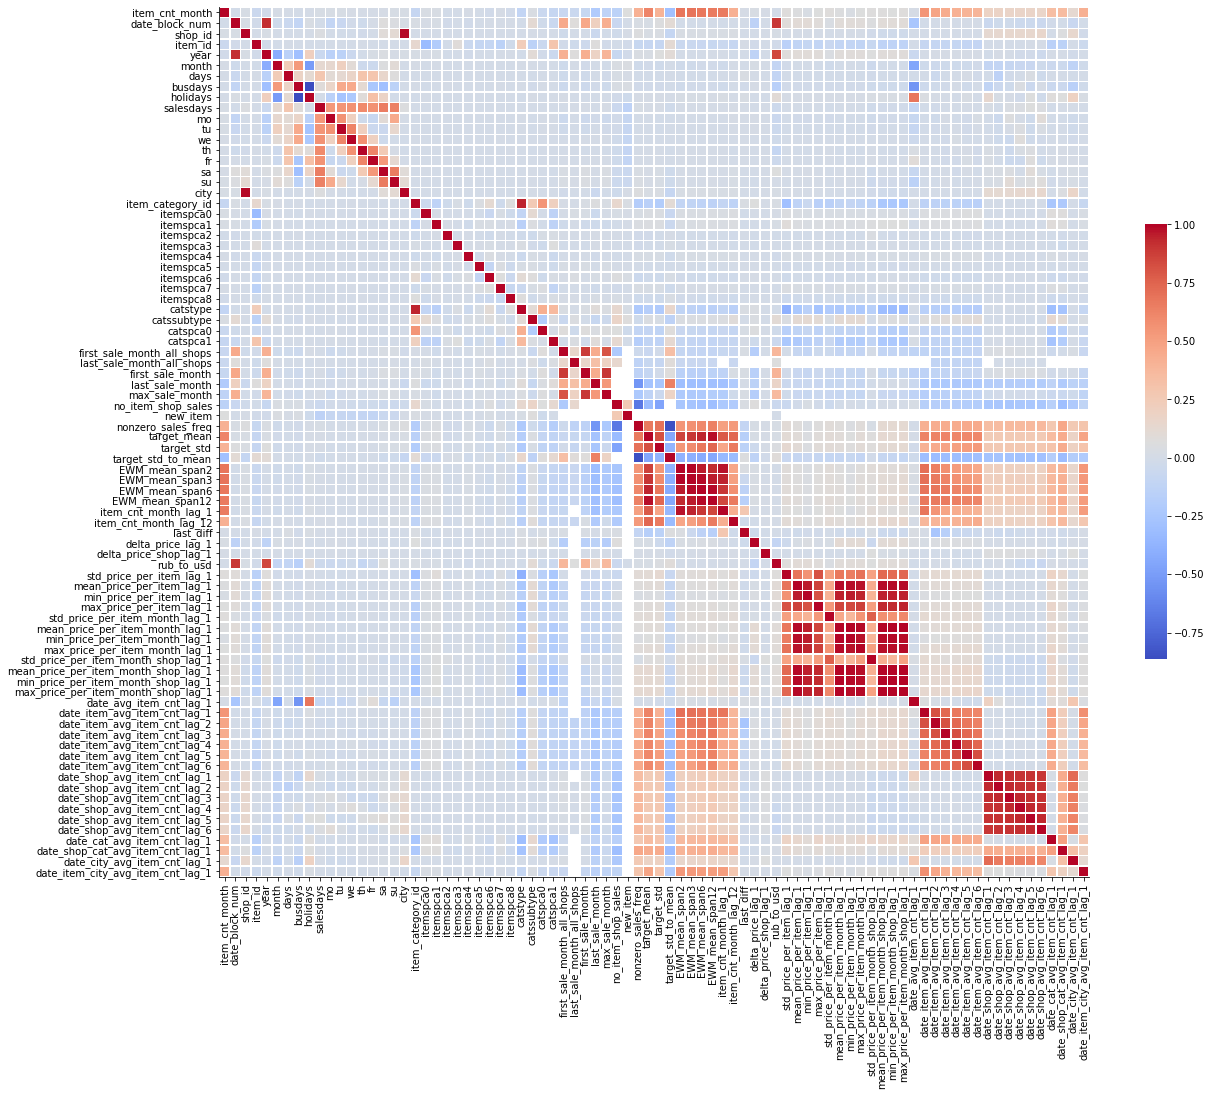

Wall time: 2min 48s


In [26]:
%%time
# Let's reorder the columns - put the target as first column
cols = ['item_cnt_month']  + [col for col in X if col != 'item_cnt_month']
X = X[cols]
# Now let's draw a correlation matrix
corr = X.corr()
g = sns.heatmap(corr,  
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False, fmt='.2f', cmap='coolwarm', xticklabels=1, yticklabels=1)
sns.despine()
g.figure.set_size_inches(20,16)
    
plt.show()